# RouterSense + Garmin Data Analysis

**Objective:** Analyze phone network activity and correlate with health metrics

This notebook will:
1. Load and explore RouterSense phone activity data
2. Load and process Garmin health metrics
3. Merge datasets on hourly timestamps
4. Analyze correlations between phone usage and health
5. Visualize patterns and relationships
6. Generate insights and recommendations

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

print("✓ Imports successful!")

✓ Imports successful!


## 1. Load RouterSense Data

Load the phone activity data and explore its structure.

In [2]:
# Load RouterSense data
print("Loading RouterSense data...")
df_router = pd.read_csv('../data/phone_overall_activities.csv')

# Convert timestamp to datetime
df_router['datetime'] = pd.to_datetime(df_router['timestamp'], unit='s')

print(f"✓ Loaded {len(df_router):,} network activity records")
print(f"  Date range: {df_router['datetime'].min()} to {df_router['datetime'].max()}")
print(f"\nDataset shape: {df_router.shape}")
print(f"\nColumns: {list(df_router.columns)}")

Loading RouterSense data...
✓ Loaded 432,291 network activity records
  Date range: 2025-10-27 05:39:00 to 2025-12-03 18:02:50

Dataset shape: (432291, 13)

Columns: ['Unnamed: 0', 'timestamp', 'device_ip_address', 'remote_ip_address', 'remote_hostname', 'remote_port', 'protocol', 'upload_byte_count', 'upload_packet_count', 'download_byte_count', 'download_packet_count', 'metadata_json', 'datetime']


In [3]:
# Preview the data
df_router.head(10)

,Unnamed: 0,timestamp,device_ip_address,remote_ip_address,remote_hostname,remote_port,protocol,upload_byte_count,upload_packet_count,download_byte_count,download_packet_count,metadata_json,datetime
0,0,1761543540,10.7.0.54,10.83.12.118,pi.hole,53,udp,363,6,0,0,"{""registered_domain"":"""",""entity_name"":""""}",2025-10-27 05:39:00
1,1,1761543540,10.7.0.54,10.83.12.118,pi.hole,853,tcp,64,1,40,1,"{""registered_domain"":"""",""entity_name"":""""}",2025-10-27 05:39:00
2,2,1761543540,10.7.0.54,104.131.155.175,0.pool.ntp.org,123,udp,76,1,76,1,"{""registered_domain"":""ntp.org"",""entity_name"":""...",2025-10-27 05:39:00
3,3,1761543540,10.7.0.54,142.251.163.188,mtalk.google.com,5228,tcp,1350,11,7870,11,"{""registered_domain"":""google.com"",""entity_name...",2025-10-27 05:39:00
4,4,1761543540,10.7.0.54,170.187.142.180,0.pool.ntp.org,123,udp,76,1,76,1,"{""registered_domain"":""ntp.org"",""entity_name"":""...",2025-10-27 05:39:00
5,5,1761543540,10.7.0.54,66.59.198.178,3.pool.ntp.org,123,udp,76,1,76,1,"{""registered_domain"":""ntp.org"",""entity_name"":""...",2025-10-27 05:39:00
6,6,1761543540,10.7.0.54,74.208.14.149,1.pool.ntp.org,123,udp,76,1,76,1,"{""registered_domain"":""ntp.org"",""entity_name"":""...",2025-10-27 05:39:00
7,7,1761543570,10.7.0.54,10.83.12.118,pi.hole,53,udp,69,1,0,0,"{""registered_domain"":"""",""entity_name"":""""}",2025-10-27 05:39:30
8,8,1761543570,10.7.0.54,216.239.34.223,youtubei.googleapis.com,443,tcp,1674,7,2716,5,"{""registered_domain"":""googleapis.com"",""entity_...",2025-10-27 05:39:30
9,9,1761543570,10.7.0.54,216.239.34.223,youtubei.googleapis.com,443,udp,10738,16,6111,12,"{""registered_domain"":""googleapis.com"",""entity_...",2025-10-27 05:39:30


## 2. Parse Metadata and Calculate Metrics

In [4]:
# Parse metadata JSON to extract domain and company
def parse_metadata(meta_str):
    try:
        meta = json.loads(meta_str)
        return meta.get('registered_domain', ''), meta.get('entity_name', '')
    except:
        return '', ''

df_router[['domain', 'company']] = df_router['metadata_json'].apply(
    lambda x: pd.Series(parse_metadata(x))
)

# Calculate total bandwidth
df_router['total_bytes'] = df_router['upload_byte_count'] + df_router['download_byte_count']
df_router['total_packets'] = df_router['upload_packet_count'] + df_router['download_packet_count']
df_router['total_mb'] = df_router['total_bytes'] / 1e6

print(f"✓ Parsed metadata")
print(f"  Unique domains: {df_router['domain'].nunique()}")
print(f"  Unique companies: {df_router['company'].nunique()}")

✓ Parsed metadata
  Unique domains: 885
  Unique companies: 299


In [5]:
# Preview with new columns
df_router[['datetime', 'domain', 'company', 'total_mb', 'protocol']].head(10)

,datetime,domain,company,total_mb,protocol
0,2025-10-27 05:39:00,,,0.000363,udp
1,2025-10-27 05:39:00,,,0.000104,tcp
2,2025-10-27 05:39:00,ntp.org,Network Time Foundation,0.000152,udp
3,2025-10-27 05:39:00,google.com,Google,0.009220,tcp
4,2025-10-27 05:39:00,ntp.org,Network Time Foundation,0.000152,udp
5,2025-10-27 05:39:00,ntp.org,Network Time Foundation,0.000152,udp
6,2025-10-27 05:39:00,ntp.org,Network Time Foundation,0.000152,udp
7,2025-10-27 05:39:30,,,0.000069,udp
8,2025-10-27 05:39:30,googleapis.com,Google,0.004390,tcp
9,2025-10-27 05:39:30,googleapis.com,Google,0.016849,udp


## 3. Explore Top Domains and Companies

In [6]:
# Top 20 domains by total bandwidth
top_domains = df_router.groupby('domain').agg({
    'total_mb': 'sum',
    'remote_hostname': 'count'
}).sort_values('total_mb', ascending=False).head(20)

top_domains.columns = ['Total MB', 'Connections']

print("Top 20 Domains by Bandwidth:\n")
print(top_domains)

Top 20 Domains by Bandwidth:

                           Total MB  Connections
domain                                          
googlevideo.com        52771.221738        31826
gccrunchyroll.com      36119.041772         1631
akamaized.net          34762.514756         1573
crunchyrollcdn.com     20783.327703         1004
nflxvideo.net          18992.417179         3739
googleapis.com          9195.912773        96033
gvt1.com                3343.320509         4928
redd.it                 1834.742324         2712
nflxso.net              1677.633192          553
reddit.com              1325.671223        11942
redditmedia.com         1138.057733         2456
vrv.co                  1117.467480         1663
                        1114.754421        50511
google.com               919.432069        36733
googleusercontent.com    875.968228         4857
media-amazon.com         866.395409          997
nytimes.com              745.820129          793
giphy.com                688.619070    

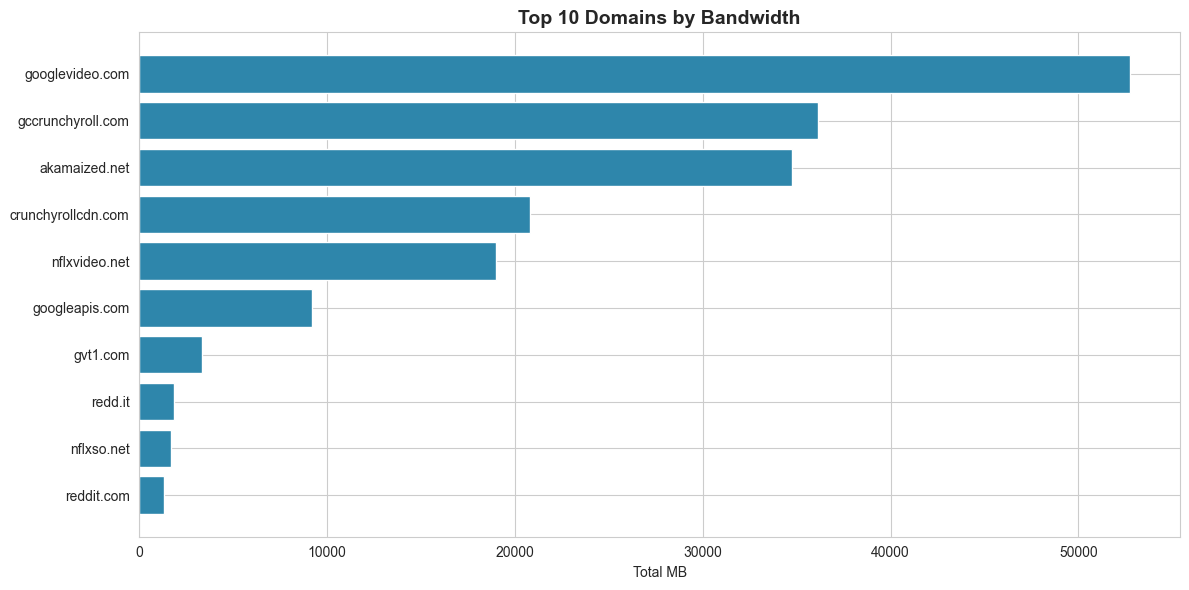

In [7]:
# Visualize top domains
plt.figure(figsize=(12, 6))
top_10 = top_domains.head(10)
plt.barh(range(len(top_10)), top_10['Total MB'], color='#2E86AB')
plt.yticks(range(len(top_10)), top_10.index)
plt.xlabel('Total MB')
plt.title('Top 10 Domains by Bandwidth', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Top companies
top_companies = df_router[df_router['company'] != ''].groupby('company').agg({
    'total_mb': 'sum',
    'remote_hostname': 'count'
}).sort_values('total_mb', ascending=False).head(10)

top_companies.columns = ['Total MB', 'Connections']

print("Top 10 Companies by Bandwidth:\n")
print(top_companies)

Top 10 Companies by Bandwidth:

                                Total MB  Connections
company                                              
Google                      68450.752650       212343
Akamai                      34768.237857         1593
Netflix                     20725.386544        10084
Reddit                       4322.222935        17177
Amazon.com                   1911.087337        11616
Facebook                     1329.351554        30617
Sony                         1302.827019        15518
The New York Times Company   1158.316154          947
Giphy                         688.619070          385
Instacart                     473.468683         5355


## 4. Aggregate to Hourly Metrics

In [9]:
# Aggregate RouterSense data to hourly
router_hourly = df_router.groupby(df_router['datetime'].dt.floor('H')).agg({
    'upload_byte_count': 'sum',
    'download_byte_count': 'sum',
    'total_bytes': 'sum',
    'total_mb': 'sum',
    'upload_packet_count': 'sum',
    'download_packet_count': 'sum',
    'total_packets': 'sum',
    'remote_hostname': 'count'
}).reset_index()

router_hourly.columns = ['datetime', 'upload_bytes', 'download_bytes', 'total_bytes',
                         'total_mb', 'upload_packets', 'download_packets', 
                         'total_packets', 'connection_count']

print(f"✓ Aggregated to {len(router_hourly)} hourly records")
print(f"  Date range: {router_hourly['datetime'].min()} to {router_hourly['datetime'].max()}")

router_hourly.head()

✓ Aggregated to 789 hourly records
  Date range: 2025-10-27 05:00:00 to 2025-12-03 18:00:00


,datetime,upload_bytes,download_bytes,total_bytes,total_mb,upload_packets,download_packets,total_packets,connection_count
0,2025-10-27 05:00:00,91503,129726,221229,0.221229,191,159,350,31
1,2025-10-27 06:00:00,5472126,1208083287,1213555413,1213.555413,34966,376881,411847,780
2,2025-10-27 07:00:00,5007325,14746669,19753994,19.753994,18505,18007,36512,571
3,2025-10-27 08:00:00,7195482,38941187,46136669,46.136669,15345,15895,31240,529
4,2025-10-27 09:00:00,1538488,5950472,7488960,7.488960,4097,4191,8288,178


## 5. Load Garmin Health Data

In [10]:
# Load parsed Garmin data
parsed_dir = Path('../output/garmin_parsed')

if not parsed_dir.exists():
    print("⚠ No parsed Garmin data found!")
    print("  Please run: npm run parse")
    garmin_available = False
else:
    all_garmin_data = []
    
    for json_file in parsed_dir.glob('*.json'):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                
            # Extract records
            if 'wellness' in json_file.name.lower():
                records = data.get('records', [])
            elif 'monitoring' in json_file.name.lower():
                records = data.get('monitoring_records', [])
            else:
                records = data.get('records', [])
            
            all_garmin_data.extend(records)
        except Exception as e:
            print(f"  Warning: Could not load {json_file.name}: {e}")
    
    if all_garmin_data:
        df_garmin = pd.DataFrame(all_garmin_data)
        
        if 'timestamp' in df_garmin.columns:
            df_garmin['datetime'] = pd.to_datetime(df_garmin['timestamp'])
        
        print(f"✓ Loaded {len(df_garmin):,} Garmin records")
        print(f"  Columns: {', '.join(df_garmin.columns)}")
        garmin_available = True
    else:
        print("⚠ No Garmin records found")
        garmin_available = False

⚠ No Garmin records found


In [ ]:
# Preview Garmin data (if available)
if garmin_available:
    df_garmin.head(10)

## 6. Aggregate Garmin Data to Hourly

In [ ]:
if garmin_available:
    # Define aggregation based on available columns
    agg_dict = {}
    
    if 'heart_rate' in df_garmin.columns:
        agg_dict['heart_rate'] = 'mean'
    if 'stress_level' in df_garmin.columns:
        agg_dict['stress_level'] = 'mean'
    if 'body_battery' in df_garmin.columns:
        agg_dict['body_battery'] = 'mean'
    if 'steps' in df_garmin.columns:
        agg_dict['steps'] = 'sum'
    if 'calories' in df_garmin.columns:
        agg_dict['calories'] = 'sum'
    if 'distance' in df_garmin.columns:
        agg_dict['distance'] = 'sum'
    
    if agg_dict:
        garmin_hourly = df_garmin.groupby(df_garmin['datetime'].dt.floor('H')).agg(agg_dict).reset_index()
        
        print(f"✓ Aggregated to {len(garmin_hourly)} hourly records")
        print(f"  Metrics: {', '.join(agg_dict.keys())}")
        
        garmin_hourly.head()
    else:
        print("⚠ No recognized health metrics found")
        garmin_available = False
else:
    print("⚠ Skipping Garmin aggregation - no data available")

## 7. Merge Datasets

In [ ]:
if garmin_available:
    # Merge on datetime
    combined = pd.merge(router_hourly, garmin_hourly, on='datetime', how='inner')
    
    # Add time features
    combined['hour'] = combined['datetime'].dt.hour
    combined['day_of_week'] = combined['datetime'].dt.dayofweek
    combined['is_weekend'] = combined['day_of_week'].isin([5, 6])
    combined['date'] = combined['datetime'].dt.date
    
    print(f"✓ Merged dataset: {len(combined)} records")
    print(f"  Date range: {combined['datetime'].min()} to {combined['datetime'].max()}")
    
    # Save combined dataset
    output_dir = Path('../output/analysis_results')
    output_dir.mkdir(parents=True, exist_ok=True)
    combined.to_csv(output_dir / 'combined_hourly.csv', index=False)
    print(f"  Saved to: {output_dir / 'combined_hourly.csv'}")
else:
    print("⚠ Using RouterSense data only (no Garmin data to merge)")
    combined = router_hourly.copy()
    combined['hour'] = combined['datetime'].dt.hour
    combined['day_of_week'] = combined['datetime'].dt.dayofweek
    combined['is_weekend'] = combined['day_of_week'].isin([5, 6])

combined.head()

## 8. Summary Statistics

In [ ]:
print("="*70)
print("SUMMARY STATISTICS")
print("="*70)

print("\nNetwork Usage:")
print(f"  Total data: {combined['total_mb'].sum():.2f} MB")
print(f"  Avg per hour: {combined['total_mb'].mean():.2f} MB")
print(f"  Peak hour: {combined['total_mb'].max():.2f} MB")
print(f"  Avg connections/hour: {combined['connection_count'].mean():.0f}")

if 'stress_level' in combined.columns:
    print("\nHealth Metrics:")
    print(f"  Avg stress: {combined['stress_level'].mean():.1f}")
    print(f"  Max stress: {combined['stress_level'].max():.1f}")
    
if 'heart_rate' in combined.columns:
    print(f"  Avg heart rate: {combined['heart_rate'].mean():.1f} BPM")
    print(f"  Max heart rate: {combined['heart_rate'].max():.1f} BPM")

if 'body_battery' in combined.columns:
    print(f"  Avg body battery: {combined['body_battery'].mean():.1f}")

In [ ]:
# Detailed statistics
combined.describe()

## 9. Correlation Analysis

In [ ]:
# Select key metrics for correlation
key_metrics = ['total_mb', 'connection_count']

if 'stress_level' in combined.columns:
    key_metrics.append('stress_level')
if 'heart_rate' in combined.columns:
    key_metrics.append('heart_rate')
if 'body_battery' in combined.columns:
    key_metrics.append('body_battery')
if 'steps' in combined.columns:
    key_metrics.append('steps')

if len(key_metrics) >= 2:
    corr_matrix = combined[key_metrics].corr()
    
    print("Correlation Matrix:\n")
    print(corr_matrix)
    
    # Save
    corr_matrix.to_csv(output_dir / 'correlation_matrix.csv')
else:
    print("⚠ Not enough metrics for correlation analysis")

In [ ]:
# Correlation heatmap
if len(key_metrics) >= 2:
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
               fmt='.2f', square=True, linewidths=1,
               cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix: Network Usage vs Health Metrics', 
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    
    # Save
    viz_dir = Path('../output/visualizations')
    viz_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(viz_dir / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

## 10. Time Series Visualizations

In [ ]:
# Create time series plots
num_plots = 1 + sum([col in combined.columns for col in ['stress_level', 'heart_rate', 'body_battery']])

fig, axes = plt.subplots(num_plots, 1, figsize=(15, 4*num_plots))
if num_plots == 1:
    axes = [axes]

plot_idx = 0

# Network usage
axes[plot_idx].plot(combined['datetime'], combined['total_mb'], 
                    color='#2E86AB', linewidth=1.5)
axes[plot_idx].set_title('Network Usage Over Time', fontweight='bold', fontsize=12)
axes[plot_idx].set_ylabel('Total MB')
axes[plot_idx].grid(True, alpha=0.3)
plot_idx += 1

# Stress level
if 'stress_level' in combined.columns:
    axes[plot_idx].plot(combined['datetime'], combined['stress_level'], 
                        color='#A23B72', linewidth=1.5)
    axes[plot_idx].set_title('Stress Level Over Time', fontweight='bold', fontsize=12)
    axes[plot_idx].set_ylabel('Stress (0-100)')
    axes[plot_idx].grid(True, alpha=0.3)
    plot_idx += 1

# Heart rate
if 'heart_rate' in combined.columns:
    axes[plot_idx].plot(combined['datetime'], combined['heart_rate'], 
                        color='#F18F01', linewidth=1.5)
    axes[plot_idx].set_title('Heart Rate Over Time', fontweight='bold', fontsize=12)
    axes[plot_idx].set_ylabel('BPM')
    axes[plot_idx].grid(True, alpha=0.3)
    plot_idx += 1

# Body battery
if 'body_battery' in combined.columns:
    axes[plot_idx].plot(combined['datetime'], combined['body_battery'], 
                        color='#06A77D', linewidth=1.5)
    axes[plot_idx].set_title('Body Battery Over Time', fontweight='bold', fontsize=12)
    axes[plot_idx].set_ylabel('Energy (0-100)')
    axes[plot_idx].set_xlabel('Date')
    axes[plot_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / 'time_series_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Scatter Plots: Network Usage vs Health

In [ ]:
# Scatter plots with trend lines
has_stress = 'stress_level' in combined.columns
has_hr = 'heart_rate' in combined.columns
has_battery = 'body_battery' in combined.columns

num_plots = sum([has_stress, has_hr, has_battery])

if num_plots > 0:
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))
    if num_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # Network usage vs Stress
    if has_stress:
        axes[plot_idx].scatter(combined['total_mb'], combined['stress_level'], 
                              alpha=0.5, color='#A23B72')
        axes[plot_idx].set_xlabel('Network Usage (MB)')
        axes[plot_idx].set_ylabel('Stress Level')
        axes[plot_idx].set_title('Network Usage vs Stress', fontweight='bold')
        axes[plot_idx].grid(True, alpha=0.3)
        
        # Trend line
        z = np.polyfit(combined['total_mb'].dropna(), combined['stress_level'].dropna(), 1)
        p = np.poly1d(z)
        axes[plot_idx].plot(combined['total_mb'], p(combined['total_mb']), 
                           "r--", alpha=0.8, linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
        axes[plot_idx].legend()
        plot_idx += 1
    
    # Network usage vs Heart Rate
    if has_hr:
        axes[plot_idx].scatter(combined['total_mb'], combined['heart_rate'], 
                              alpha=0.5, color='#F18F01')
        axes[plot_idx].set_xlabel('Network Usage (MB)')
        axes[plot_idx].set_ylabel('Heart Rate (BPM)')
        axes[plot_idx].set_title('Network Usage vs Heart Rate', fontweight='bold')
        axes[plot_idx].grid(True, alpha=0.3)
        
        z = np.polyfit(combined['total_mb'].dropna(), combined['heart_rate'].dropna(), 1)
        p = np.poly1d(z)
        axes[plot_idx].plot(combined['total_mb'], p(combined['total_mb']), 
                           "r--", alpha=0.8, linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
        axes[plot_idx].legend()
        plot_idx += 1
    
    # Network usage vs Body Battery
    if has_battery:
        axes[plot_idx].scatter(combined['total_mb'], combined['body_battery'], 
                              alpha=0.5, color='#06A77D')
        axes[plot_idx].set_xlabel('Network Usage (MB)')
        axes[plot_idx].set_ylabel('Body Battery')
        axes[plot_idx].set_title('Network Usage vs Body Battery', fontweight='bold')
        axes[plot_idx].grid(True, alpha=0.3)
        
        z = np.polyfit(combined['total_mb'].dropna(), combined['body_battery'].dropna(), 1)
        p = np.poly1d(z)
        axes[plot_idx].plot(combined['total_mb'], p(combined['total_mb']), 
                           "r--", alpha=0.8, linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
        axes[plot_idx].legend()
    
    plt.tight_layout()
    plt.savefig(viz_dir / 'scatter_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠ No health metrics available for scatter plots")

## 12. Hourly Patterns Analysis

In [ ]:
# Analyze patterns by hour of day
hourly_avg = combined.groupby('hour').agg({
    'total_mb': 'mean',
    'connection_count': 'mean'
})

if 'stress_level' in combined.columns:
    hourly_avg['stress_level'] = combined.groupby('hour')['stress_level'].mean()
if 'heart_rate' in combined.columns:
    hourly_avg['heart_rate'] = combined.groupby('hour')['heart_rate'].mean()

hourly_avg

In [ ]:
# Visualize hourly patterns
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Network usage by hour
axes[0].bar(hourly_avg.index, hourly_avg['total_mb'], 
           color='#2E86AB', alpha=0.7)
axes[0].set_title('Average Network Usage by Hour of Day', fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average MB')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(24))

# Stress by hour (if available)
if 'stress_level' in hourly_avg.columns:
    axes[1].bar(hourly_avg.index, hourly_avg['stress_level'], 
               color='#A23B72', alpha=0.7)
    axes[1].set_title('Average Stress Level by Hour of Day', fontweight='bold')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Average Stress')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_xticks(range(24))
else:
    axes[1].bar(hourly_avg.index, hourly_avg['connection_count'], 
               color='#F18F01', alpha=0.7)
    axes[1].set_title('Average Connections by Hour of Day', fontweight='bold')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Average Connections')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_xticks(range(24))

plt.tight_layout()
plt.savefig(viz_dir / 'hourly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Key Insights Summary

In [ ]:
print("="*70)
print("KEY INSIGHTS")
print("="*70)

# Peak usage hour
peak_hour = hourly_avg['total_mb'].idxmax()
print(f"\n📱 Peak Usage Hour: {peak_hour}:00 ({hourly_avg.loc[peak_hour, 'total_mb']:.2f} MB avg)")

# Top domain
print(f"\n🌐 Top Domain: {top_domains.index[0]} ({top_domains.iloc[0]['Total MB']:.2f} MB total)")

# Correlation insights
if 'stress_level' in combined.columns:
    stress_corr = combined[['total_mb', 'stress_level']].corr().iloc[0, 1]
    print(f"\n😰 Network Usage vs Stress Correlation: {stress_corr:.3f}")
    if stress_corr > 0.3:
        print("   → Moderate positive correlation: More usage = Higher stress")
    elif stress_corr > 0.1:
        print("   → Weak positive correlation: Slight stress increase with usage")
    elif stress_corr < -0.1:
        print("   → Negative correlation: More usage = Lower stress (relaxation?)")
    else:
        print("   → No significant correlation")

if 'heart_rate' in combined.columns:
    hr_corr = combined[['total_mb', 'heart_rate']].corr().iloc[0, 1]
    print(f"\n❤️  Network Usage vs Heart Rate Correlation: {hr_corr:.3f}")

if 'body_battery' in combined.columns:
    bb_corr = combined[['total_mb', 'body_battery']].corr().iloc[0, 1]
    print(f"\n🔋 Network Usage vs Body Battery Correlation: {bb_corr:.3f}")
    if bb_corr < -0.2:
        print("   → Phone usage drains energy!")

print("\n" + "="*70)
print("Analysis complete! Check output/ directory for saved results.")
print("="*70)

## 14. Export Results

In [ ]:
# Save top domains
top_domains.to_csv(output_dir / 'top_domains.csv')
print(f"✓ Saved top domains to: {output_dir / 'top_domains.csv'}")

# Save hourly patterns
hourly_avg.to_csv(output_dir / 'hourly_patterns.csv')
print(f"✓ Saved hourly patterns to: {output_dir / 'hourly_patterns.csv'}")

print("\n📊 All results saved to output/ directory!")
print("   - Data: output/analysis_results/")
print("   - Visualizations: output/visualizations/")